In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl  
import pandas as pd
import re;
import sys;
import os;

#result visualization script
# prediction_visualization.ipynb by dellacortelab
# modified by yamule
# LGPLv3

def load_dist(fileName): 
    fileObject2 = open(fileName, 'rb') 
    modelInput = pkl.load(fileObject2) 
    fileObject2.close() 
    preddist = np.argmax(modelInput[1:,:,:],axis=0)*0.317+2.317;
    return preddist;
def load_txt(fileName):
    lmax = 0;
    lines = [];
    with open(fileName) as fin:
        lines = fin.readlines();
        for ll in list(lines):
            mat1 = re.search("r1\:[\s]*([^\s]+)",ll);
            mat2 = re.search("r2\:[\s]*([^\s]+)",ll);
            if mat1 and mat2:
                lmax = max([lmax,int(mat1.group(1)),int(mat2.group(1))]);
            else:
                sys.stderr.write(ll+"????\n");
    ret = np.zeros(shape=(lmax+1,lmax+1));
    ret[:] = 22.0;
    for ll in list(lines):
        mat1 = re.search("r1\:[\s]*([^\s]+)",ll);
        mat2 = re.search("r2\:[\s]*([^\s]+)",ll);
        mat3 = re.search("dist\:[\s]*([^\s]+)",ll);
        if mat1 and mat2 and mat3:
            i = int(mat1.group(1));
            j = int(mat2.group(1));
            ret[i][j] = float(mat3.group(1));
            ret[j][i] = float(mat3.group(1));
        else:
            sys.stderr.write(ll+"????!!!\n");
    return ret;

In [41]:
source_pdb="2E74/2E74_D.pdb_d0.pdb";
prediction_result='./testout.dat.dist.res';

In [44]:
#source_pdb="1L9Y/1L9Y_A.pdb_d0.pdb"; ## Please see readme.txt
#prediction_result='1L9Y/1L9Y_A.pdb_d0.prosprres.dist.res';

In [46]:
import re;
import os;
import sys;
import math;

aa_3_1_ = {
"ALA":"A",
"ARG":"R",
"ASN":"N",
"ASP":"D",
"CYS":"C",
"GLN":"Q",
"GLU":"E",
"GLY":"G",
"HIS":"H",
"ILE":"I",
"LEU":"L",
"LYS":"K",
"MET":"M",
"PHE":"F",
"PRO":"P",
"SER":"S",
"THR":"T",
"TRP":"W",
"TYR":"Y",
"VAL":"V"
};

aa_1_3_={};

for ii in aa_3_1_.keys():
    aa_1_3_[aa_3_1_[ii]] = ii;

def aa_3_1(a):
    if a in aa_3_1_:
        return aa_3_1_[a];
    return "X";

def aa_1_3(a):
    if a in aa_1_3_:
        return aa_1_3_[a];
    return "UNK";

class PDBData:
    
    def __init__(self):
        self.chains = [];
    
    def get_ca_atoms(self):
        chain_ca_atoms=[];
        printed={};
        for cc in self.chains:
            cas = [];
            printed_res = {};
            for aa in cc.atoms:
                alabel = aa.get_atom_label();
                printed_res[aa.get_residue_label()] = 100;
                if alabel in printed:
                    continue;
                printed[alabel] = 100;
                if aa.atom_name == "CA":
                    cas.append(aa);
            if len(cas) != len(printed_res):
                print("Some residues in "+cc.name+ " do not have CA!");
            chain_ca_atoms.append(cas);
        return chain_ca_atoms;
    
    def get_cb_atoms(self):
        chain_cb_atoms=[];
        printed={};
        printed_res = {};
        for cc in self.chains:
            cbs = [];
            printed_res = {};
            for aa in cc.atoms:
                alabel = aa.get_atom_label();
                if alabel in printed:
                    continue;
                printed[alabel] = 100;
                printed_res[aa.get_residue_label()] = 100;
                if aa.atom_name == "CB":
                    cbs.append(aa);
                elif aa.residue_name == "GLY" and aa.atom_name == "CA":
                    cbs.append(aa);
            if len(cbs) != len(printed_res):
                print("Some residues in "+cc.name+ " do not have CB!");
            chain_cb_atoms.append(cbs);
        return chain_cb_atoms;
    
    @staticmethod
    def load(infilename):
        alllines = [];
        with open(infilename,encoding="utf-8") as fin:
            for ll in fin:
                alllines.append(ll);
        return PDBData.load_from_lines(alllines);
    
    @staticmethod
    def load_from_lines(alllines):
        ret = PDBData();
        atoms = [];
        ligands = [];
        chain_ended_all = False;
        chain_ended = {};
        chains = [];
        chains_hs = {};
        chains_hs_ligand = {};
        for ll in alllines:
            ll = re.sub("[\r\n]","",ll)
            head = ll[0:6] ;
            if head == "ATOM  " or head == "HETATM":
                att = PDBAtom(ll);
                if not att.chain_id in chains_hs:
                    chains.append(att.chain_id);
                    chains_hs[att.chain_id] = [];
                    chains_hs_ligand[att.chain_id] = [];

                if att.chain_id in chain_ended or chain_ended_all:
                    chains_hs_ligand[att.chain_id].append(att);
                else:
                    chains_hs[att.chain_id].append(att);
            if head == "TER   ":
                if len(ll) > 21 and ll[21]:
                    chain_ended[ll[21]] = 100;
                else:
                    chain_ended_all = True;
            if head == "ENDMDL":
                break;
        for cc in chains:
            ret.chains.append(PDBChain(cc,chains_hs[cc],chains_hs_ligand[cc]));
        return ret;

    def save(self,outfilename):
        with open(outfilename,"w") as fout:
            for cc in self.chains:
                for aa in cc.atoms:
                    fout.write(aa.make_line());
                    fout.write("\n");
                if len(cc.ligands) > 0:
                    strr = cc.atoms[-1].make_line()[6:30];
                    fout.write("TER   "+strr);
                    fout.write("\n");
                    for aa in cc.ligands:
                        fout.write(aa.make_line());
                        fout.write("\n");

class PDBChain:
    
    def __init__(self,name,atoms,ligands):
        self.name = name;
        self.atoms = atoms;
        self.ligands = ligands;
    
    def list_residues(self):
        res_printed = {};
        ret = [];
        for aa in self.atoms:
            rcode = aa.residue_name+"#"+str(aa.residue_pos)+"#"+aa.insertion_code;
            if not rcode in res_printed:
                ret.append(aa.residue_name);
                res_printed[rcode] = 100;
        return ret;
    
    def get_fasta_seq(self):
        aalist = self.list_residues();
        ret = [];
        for aa in aalist:
            if aa in aa_3_1:
                ret.append(aa_3_1[aa]);
            else:
                ret.append("X");
        return "".join(ret);
    
    def get_atom_lines(self):
        ret = [];
        for aa in self.atoms:
            ret.push(aa.make_line());
        return ret;
    
            
class PDBAtom:
    
    def __init__(self,line):
        line += "                                    ";
        self.head = line[0:6];
        self.serial_number = int(line[6:11]);
        self.atom_name = re.sub(" ","",line[12:16]);
        self.alt_loc = line[16];
        self.residue_name = re.sub("[\s]","",line[17:20]);
        self.chain_id = line[21];
        self.residue_pos = int(line[22:26]);
        self.insertion_code = line[26];
        self.x = float(line[30:38]);
        self.y = float(line[38:46]);
        self.z = float(line[46:54]);
        self.occupancy = line[54:60];
        self.bfactor = line[60:66];
        self.element = line[76:78];
        self.charge = line[79:80];
    
    #alt pos 以外を入れる
    def get_atom_label(self):
        return self.chain_id+"#"+self.residue_name+"#"+str(self.residue_pos)+"#"+self.insertion_code+"#"+self.atom_name;
    
    def get_residue_label(self):
        return self.chain_id+"#"+self.residue_name+"#"+str(self.residue_pos)+"#"+self.insertion_code;
    
    def distance(self,target):
        xx = self.x-target.x;
        yy = self.y-target.y;
        zz = self.z-target.z;
        rr = xx*xx+yy*yy+zz*zz;
        if rr == 0.0:
            return 0.0;
        return math.sqrt(rr);
        
    def make_line(self):
        xx = "{:>.3f}".format(self.x);
        yy = "{:>.3f}".format(self.y);
        zz = "{:>.3f}".format(self.z);
        
        if len(xx) > 8:
            raise Exception("string overflow".format(self.x));
        if len(yy) > 8:
            raise Exception("string overflow".format(self.y));
        if len(zz) > 8:
            raise Exception("string overflow".format(self.z));
        atomname = self.atom_name;
        if self.head == "ATOM  " and len(self.atom_name) < 4:
            atomname = " "+atomname;
        ret = "{head}{serial_number:>5} {atom_name:<4}{alt_loc}{residue_name:>3} {chain_id}{residue_pos:>4}{insertion_code}   {xx:>8}{yy:>8}{zz:>8}{occupancy:>6}{bfactor:>6}          {element:>2} {charge:2}".format(        
            head = self.head,
            serial_number = self.serial_number,
            atom_name = atomname,
            alt_loc = self.alt_loc,
            residue_name = self.residue_name,
            chain_id = self.chain_id,
            residue_pos = self.residue_pos,
            insertion_code = self.insertion_code,
            xx = xx,
            yy = yy,
            zz = zz,
            occupancy = self.occupancy,
            bfactor = self.bfactor,
            element = self.element,
            charge = self.charge);
        return ret;


# In[ ]:



In [47]:
cbs = PDBData.load(source_pdb).get_cb_atoms()[0];

Text(0, 0.5, 'Residue j')

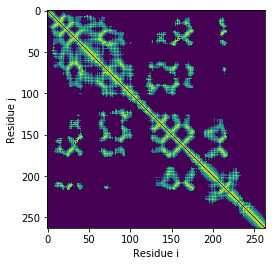

In [53]:
preddist = load_txt(prediction_result);
preddist = np.minimum(preddist,22.0);
plt.imshow(-preddist)
plt.xlabel('Residue i')
plt.ylabel('Residue j')

In [54]:
blen = len(cbs);
distt = np.zeros(shape=(blen,blen));
for aa in range(blen):
    for bb in range(aa,blen):
        distt[aa][bb] = min(22.0,cbs[aa].distance(cbs[bb]));
        #if distt[aa][bb] == 22.0:
        #    distt[aa][bb] = 40.0
        if aa != bb:
            distt[bb][aa] = distt[aa][bb];

Text(0, 0.5, 'Residue j')

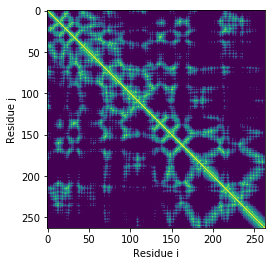

In [55]:
plt.imshow(-distt)
plt.xlabel('Residue i')
plt.ylabel('Residue j')

Text(0, 0.5, 'Residue j')

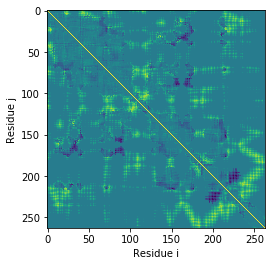

In [56]:
plt.imshow(-distt+preddist)
plt.xlabel('Residue i')
plt.ylabel('Residue j')